# Model Training

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../')
from utils.machine_learning import preprocess_pipeline, evaluate_models, visualize_roc_curves, visualize_confusion_matrix, initiate_model_trainer, plot_precision_recall_threshold, plot_feature_importance

# Data

In [2]:
df_original = pd.read_csv("./Ml_Datasets/original.csv")
df_all = pd.read_csv("./Ml_Datasets/all_features.csv")

# Preprocessing the Data

In [3]:
X_train_original, X_test_original, y_train_original, y_test_original = preprocess_pipeline(df_original, test_size=0.3, target_name="target")
X_train_all, X_test_all, y_train_all, y_test_all = preprocess_pipeline(df_all, test_size=0.3, target_name="target")

# Models on Original Features

## Using class_weight = balanced

In [4]:
model_report_original = initiate_model_trainer((X_train_original, y_train_original, X_test_original, y_test_original), "Original_Features", use_smote=False)

Successfully registered model 'Logistic Regression - Original_Features'.
2024/02/05 01:30:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression - Original_Features, version 1
Created version '1' of model 'Logistic Regression - Original_Features'.
Successfully registered model 'Random Forest - Original_Features'.
2024/02/05 02:00:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest - Original_Features, version 1
Created version '1' of model 'Random Forest - Original_Features'.
Successfully registered model 'KNN - Original_Features'.
2024/02/05 02:00:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: KNN - Original_Features, version 1
Created version '1' of model 'KNN - Original_Features'.


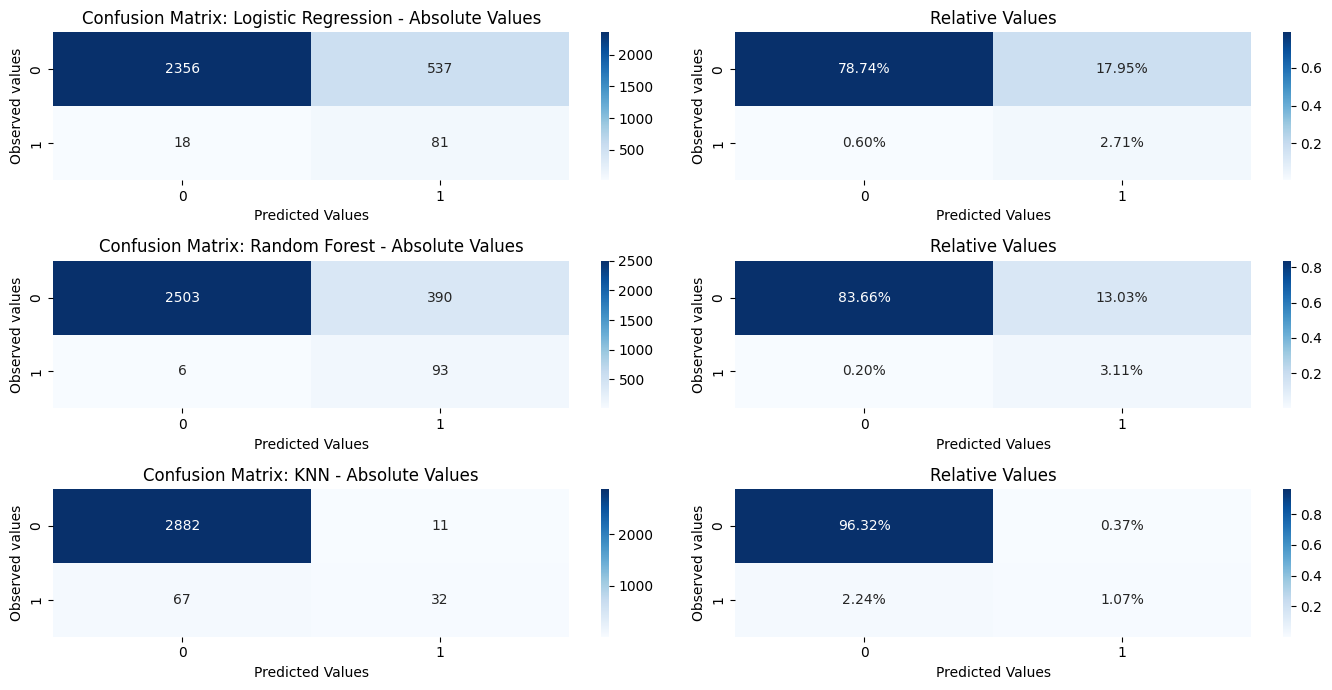

In [5]:
visualize_confusion_matrix(y_test_original, model_report_original, 3, 2)

### Observations:
- The logistic regression model had an extremely high number of false positives, indicating that the model has very little `precision`. Despite having a high `recall`, the amount of false positives makes this model far from ideal in an industry environment
- The random forest model only failed to report four machines as machines susceptible to failures, but similarly to the logistic regression model, it has a lot of false positives.
- The KNN model was the overall best performer when looking exclusively at metrics. But compared to the other two, it failed to detect the majority of the machines that would actually need maintenance, with a lot of false negatives and an extremely low `recall`

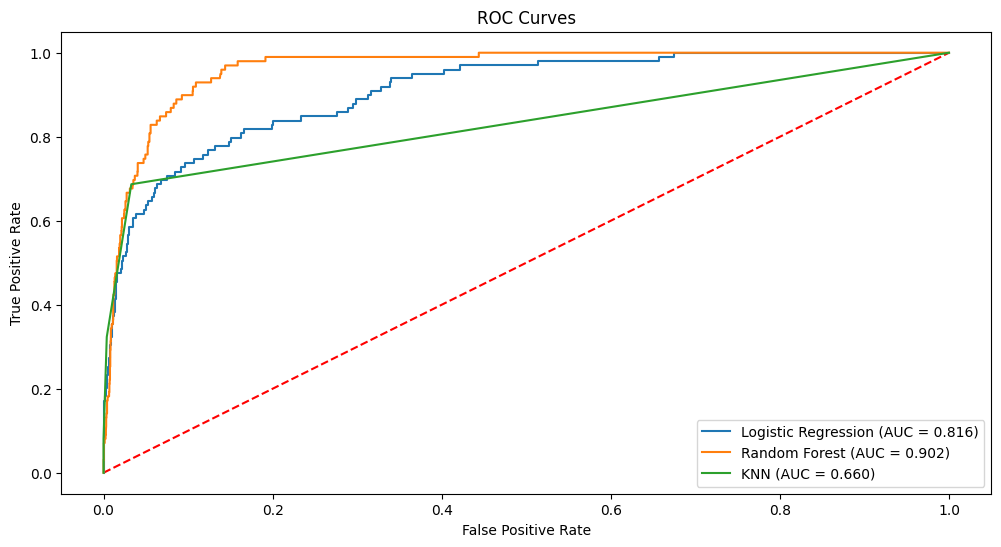

In [6]:
visualize_roc_curves(model_report_original)

### Observations:
- The random forest model is the clear winner when plotting the `ROC` curves, with a score of 0.92. This indicates that the random forest model is excellent at discriminating the data between both classes, covering a large area under the curve
- The logistic regression model demonstrated that it's somewhat capable of discriminating the data, but its not close to the random forest model
- Looking only at the metrics, the KNN model seemed like it was the best model, performance wise. But looking at it's `ROC` curve, it's clear that the model is extremely bad at discriminating the data between both classes, with a score of only 0.66


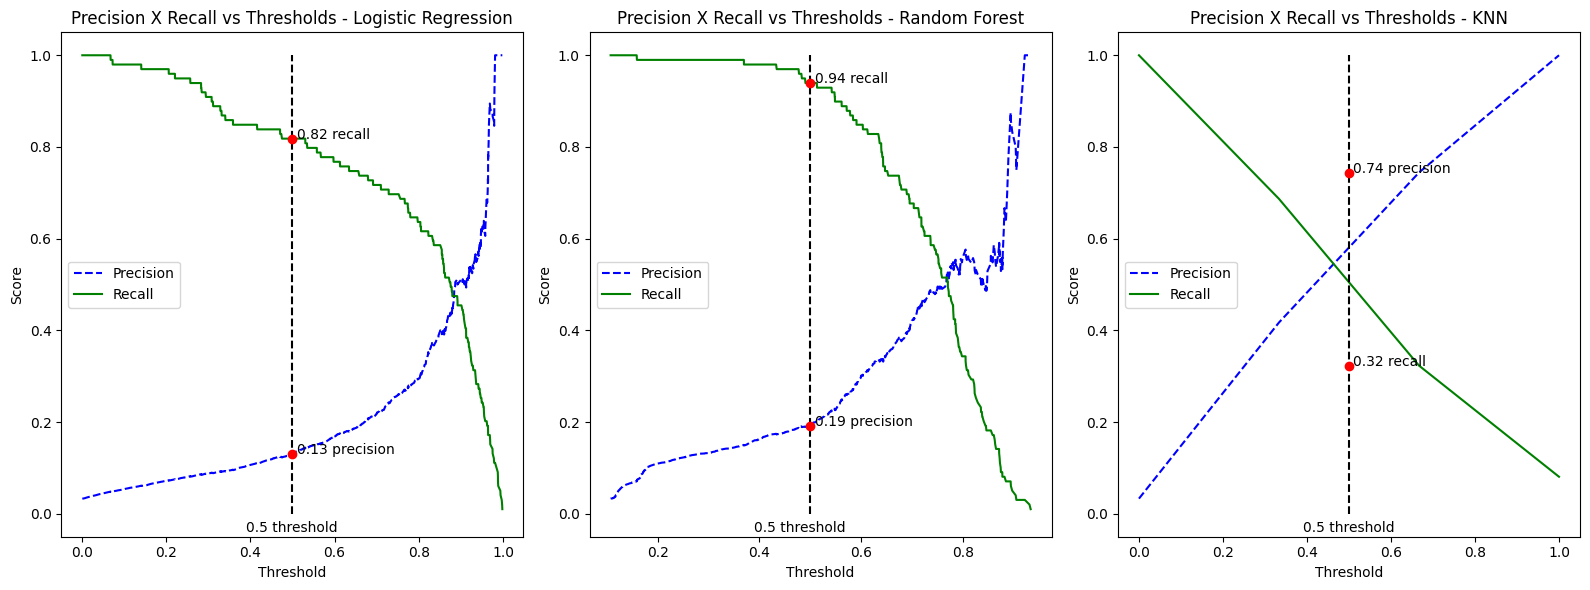

In [7]:
plot_precision_recall_threshold(y_test_original, X_test_original, model_report_original, 1, 3)

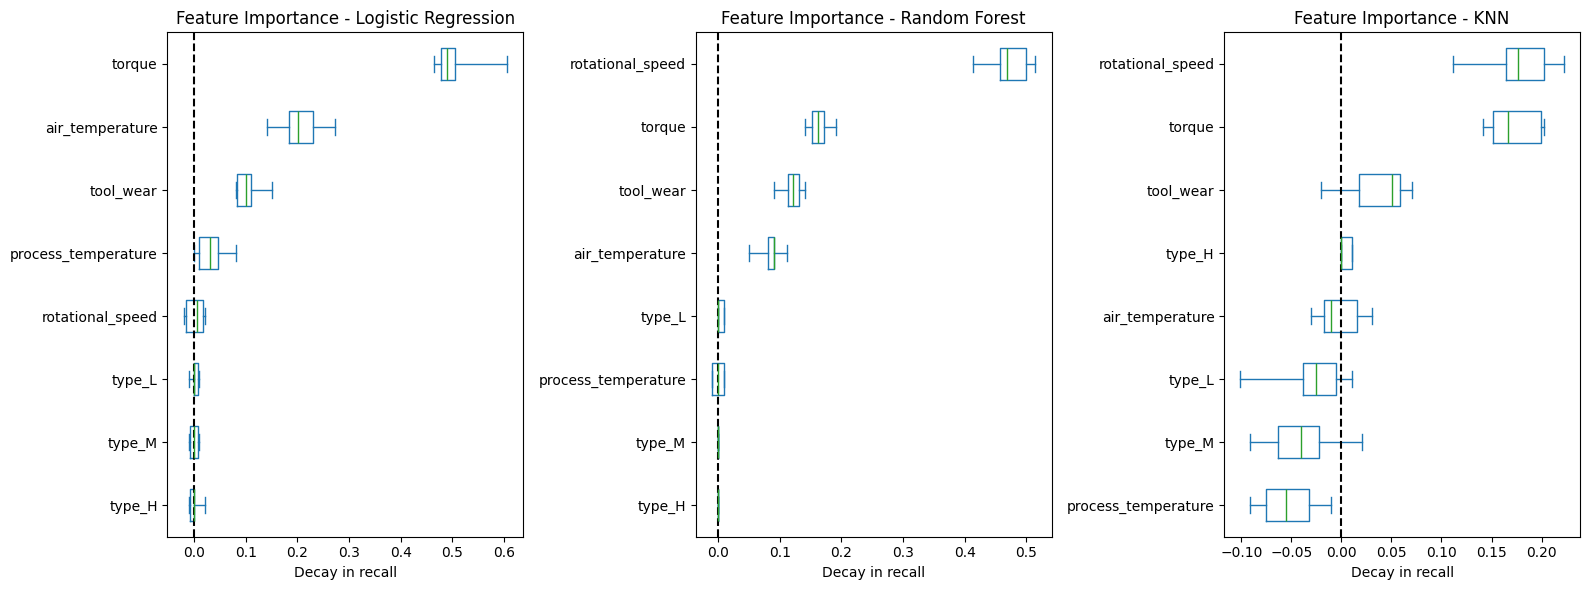

In [8]:
plot_feature_importance(y_test_original, X_test_original, model_report_original, "recall", 1, 3)

A decay in recall of 0.6 implies that permuting the values of this feature results in an average decrease of 0.6 in the model's recall.
This suggests that the original model relies on the correct values of this feature for making predictions, and shuffling or changing this feature has a noticeable negative impact on the model's ability to recall positive instances.
In simpler terms, a higher decay in recall value for a feature indicates that the model heavily relies on that feature for correctly identifying positive instances. A lower decay suggests that the feature might not be as critical for recall in the model.

It's essential to consider the context of your specific problem and the trade-offs between features when interpreting these decay values.

## Using SMOTE

In [9]:
model_report_original_smote = initiate_model_trainer((X_train_original, y_train_original, X_test_original, y_test_original), "Original_Features", use_smote=True)

Registered model 'Logistic Regression - Original_Features' already exists. Creating a new version of this model...
2024/02/04 21:54:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression - Original_Features, version 2
Created version '2' of model 'Logistic Regression - Original_Features'.
Registered model 'Random Forest - Original_Features' already exists. Creating a new version of this model...
2024/02/04 23:19:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest - Original_Features, version 2
Created version '2' of model 'Random Forest - Original_Features'.
Registered model 'KNN - Original_Features' already exists. Creating a new version of this model...
2024/02/04 23:19:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: KNN - Or